#  Data Drift Analysis: Standalone Monitoring

Este notebook realiza el análisis de data drift (desviación de datos) de forma independiente, importando los datos preprocesados y escalados directamente desde `Feature_eng.py`. Utilizamos **Kolmogorov-Smirnov (KS) tests** y **Plotly** para visualizar los cambios distributivos.

---

##  Contenido:

1. **Vista de Cronograma:** Distribución sobre los períodos (Histograma + Serie de Tiempo).
2. **Tabla de Estadísticas de Desviación:** Nombre de la característica, valor p del test KS, desviación detectada.
3. **Resaltado:** Heatmap para desviación significativa (p < 0.05).
4. **Resumen:** Top 5 características con mayor desviación e interpretación.

In [9]:
# Importaciones necesarias
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns # Añadido para el Heatmap

# Configuración de Matplotlib/Seaborn
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# ===================================================================
# 1. Importación Directa de Datos Procesados desde Feature_eng.py
# ===================================================================
try:
    from Feature_eng import (
        train_scaled, 
        val_scaled, 
        test_scaled, 
        feat_cols, 
        data_with_y
    )
except ImportError:
    print("ERROR: Asegúrese de que 'Feature_eng.py' existe y ha sido ejecutado para crear las variables escaladas.")
    raise

# Intento de asegurar que 'date' está presente para la visualización de cronograma
if 'date' not in train_scaled.columns and 'date' in data_with_y.columns:
    print("ADVERTENCIA: Recreando columna 'date' para cronograma.")
    try:
        train_scaled['date'] = data_with_y.loc[train_scaled.index, 'date'].reset_index(drop=True)
        val_scaled['date'] = data_with_y.loc[val_scaled.index, 'date'].reset_index(drop=True)
        test_scaled['date'] = data_with_y.loc[test_scaled.index, 'date'].reset_index(drop=True)
    except Exception:
        print("ERROR: Fallo al alinear las fechas. La vista de cronograma no mostrará el eje X correctamente.")


print(f"Datos importados. Total features: {len(feat_cols)}")
print(f"Train samples: {len(train_scaled)}, Validation samples: {len(val_scaled)}, Test samples: {len(test_scaled)}")

Datos importados. Total features: 40
Train samples: 2242, Validation samples: 748, Test samples: 748


In [17]:
# ===================================================================
# 2. Data Drift Logic (Funciones de Cálculo y Matplotlib)
# ===================================================================

def compute_drift_statistics():
    """Calcula estadísticas de drift para todas las features usando KS-test."""
    results = []
    testable_features = [f for f in feat_cols if pd.api.types.is_numeric_dtype(train_scaled[f])]
    
    for feature in testable_features:
        try:
            train_vals = train_scaled[feature].dropna().values
            val_vals = val_scaled[feature].dropna().values
            ks_tv, p_tv = stats.ks_2samp(train_vals, val_vals)
            
            test_vals = test_scaled[feature].dropna().values
            ks_tt, p_tt = stats.ks_2samp(train_vals, test_vals)
            
            drift_detected = (p_tv < 0.05) or (p_tt < 0.05)
            
            results.append({
                'Feature': feature,
                'KS_Stat_TrainVal': ks_tv,
                'P_Value_TrainVal': p_tv,
                'KS_Stat_TrainTest': ks_tt,
                'P_Value_TrainTest': p_tt,
                'Drift_Detected': drift_detected,
                'Max_KS_Stat': max(ks_tv, ks_tt),
                'Min_P_Value': min(p_tv, p_tt)
            })
        except Exception:
            continue
    
    df_drift = pd.DataFrame(results).sort_values('Max_KS_Stat', ascending=False).reset_index(drop=True)
    return df_drift

# Requisito 2: Tabla de Estadísticas de Desviación (Mostrada en consola)
def display_drift_table_highlighted(df_drift, top_n=10):
    """Muestra tabla de drift con highlighting de features significativas en consola."""
    df_display = df_drift.head(top_n).copy()
    
    # Formatear P-Values y KS Stats para mejor visualización
    df_display['P_Value_TrainVal'] = df_display['P_Value_TrainVal'].apply(lambda x: f'{x:.6f}')
    df_display['P_Value_TrainTest'] = df_display['P_Value_TrainTest'].apply(lambda x: f'{x:.6f}')
    df_display['KS_Stat_TrainVal'] = df_display['KS_Stat_TrainVal'].apply(lambda x: f'{x:.4f}')
    df_display['KS_Stat_TrainTest'] = df_display['KS_Stat_TrainTest'].apply(lambda x: f'{x:.4f}')
    
    # Agregar símbolo de alerta
    df_display['Status'] = df_display['Drift_Detected'].apply(lambda x: '🔴 DRIFT' if x else '🟢 ESTABLE')
    
    # Columnas a mostrar
    cols = ['Feature', 'Status', 'KS_Stat_TrainVal', 'P_Value_TrainVal', 
            'KS_Stat_TrainTest', 'P_Value_TrainTest']
    
    print("--- Tabla de Estadísticas de Desviación (Top 10) ---")
    print(df_display[cols].to_markdown(index=False)) # Usamos to_markdown para un mejor formato en Jupyter

# Requisito 1: Vista de Cronograma (Matplotlib)
def plot_feature_timeline_mpl(feature):
    """
    Plotea distribución de una feature a través de los 3 periodos (Histograma y Time Series).
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Histogram/Distribution Overlay
    sns.histplot(train_scaled[feature].dropna(), bins=40, kde=True, ax=axes[0], 
                 label='Train', color='#1f77b4', stat="density", linewidth=0, alpha=0.6)
    sns.histplot(val_scaled[feature].dropna(), bins=40, kde=True, ax=axes[0], 
                 label='Validation', color='#ff7f0e', stat="density", linewidth=0, alpha=0.6)
    sns.histplot(test_scaled[feature].dropna(), bins=40, kde=True, ax=axes[0], 
                 label='Test', color='#2ca02c', stat="density", linewidth=0, alpha=0.6)
                 
    axes[0].set_title(f'{feature} - Distribution Overlay (Train vs Val vs Test)', fontsize=14)
    axes[0].set_xlabel('Valor Escaldo')
    axes[0].set_ylabel('Densidad')
    axes[0].legend()
    
    # 2. Time Series Evolution
    if 'date' in train_scaled.columns:
        # Concatenar para mostrar la evolución temporal y resaltar periodos
        full_df = pd.concat([train_scaled, val_scaled, test_scaled]).sort_values('date').reset_index(drop=True)
        
        n_train = len(train_scaled)
        n_val = len(val_scaled)
        
        # Plot Train
        axes[1].plot(full_df['date'][:n_train], full_df[feature][:n_train], 
                     label='Train', linewidth=1.5, color='#1f77b4')
        # Plot Validation
        axes[1].plot(full_df['date'][n_train:n_train+n_val], full_df[feature][n_train:n_train+n_val], 
                     label='Validation', linewidth=2, color='#ff7f0e')
        # Plot Test
        axes[1].plot(full_df['date'][n_train+n_val:], full_df[feature][n_train+n_val:], 
                     label='Test', linewidth=2.5, color='#2ca02c')

        axes[1].set_title(f'{feature} - Time Series Evolution', fontsize=14)
        axes[1].set_xlabel('Fecha')
        axes[1].set_ylabel('Valor Escaldo')
        axes[1].legend()
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].text(0.5, 0.5, 'Fecha no disponible para el Cronograma', 
                       ha='center', va='center', fontsize=12)
        axes[1].set_title('Time Series Evolution')

    plt.suptitle(f'Vista de Cronograma: {feature}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Requisito 3: Resaltado (Heatmap con Seaborn)
def plot_drift_heatmap_mpl(df_drift):
    """Genera Heatmap con highlighting de p-values para identificar drift."""
    # Preparar matriz de P-Values para el Heatmap
    drift_matrix = df_drift[['Feature', 'P_Value_TrainVal', 'P_Value_TrainTest']].copy()
    drift_matrix = drift_matrix.set_index('Feature')
    drift_matrix.columns = ['Train vs Val', 'Train vs Test']
    
    fig, ax = plt.subplots(figsize=(8, max(10, len(drift_matrix) * 0.35)))
    
    # cmap='RdYlGn_r': Rojo (Drift) <--- 0.05 <--- Verde (Estable)
    sns.heatmap(
        drift_matrix.astype(float),
        annot=True,
        fmt='.6f',
        cmap='RdYlGn_r',  
        center=0.05,      
        vmin=0,
        vmax=0.15,
        cbar_kws={'label': 'P-Value'},
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    
    plt.title('Data Drift Detection Heatmap (Resaltado: p < 0.05)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.xlabel('Comparación de Período', fontsize=12, fontweight='bold')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Requisito 4: Resumen (Top 5 con Interpretación)
def generate_top5_summary(df_drift):
    """Genera resumen interpretativo de las top 5 features con mayor drift."""
    top5 = df_drift.head(5).copy(); interpretations = []
    
    for idx, row in top5.iterrows():
        feature = row['Feature']; max_ks = row['Max_KS_Stat']; min_p = row['Min_P_Value']
        status = '🔴 CRÍTICO' if min_p < 0.01 else '🟠 ALTO' if min_p < 0.05 else '🟡 MODERADO'
        
        # Interpretación contextual basada en tipo de indicador
        if any(x in feature for x in ['ATR', 'Volatility', 'BB', 'KC', 'Donchian']):
            interpretation = 'Cambio en volatilidad. Posible transición entre régimen de baja/alta volatilidad.'
        elif any(x in feature for x in ['RSI', 'MACD', 'ROC', 'Stoch', 'Momentum', 'Williams', 'AO']):
            interpretation = 'Shift en momentum. Indica cambio de sentimiento alcista/bajista.'
        elif any(x in feature for x in ['Volume', 'OBV', 'VROC', 'MFI', 'CMF', 'AD', 'EOM']):
            interpretation = 'Cambio en patrones de volumen. Puede indicar cambio en liquidez o interés en el activo.'
        elif any(x in feature for x in ['MA', 'EMA', 'ADX', 'PSAR', 'Ichimoku']):
            interpretation = 'Cambio en indicadores de tendencia. Posible reversión o cambio de régimen tendencial.'
        else:
            interpretation = 'Cambio distributivo significativo. Requiere análisis detallado del contexto de mercado.'
        
        magnitude = 'EXTREMA' if max_ks > 0.3 else 'ALTA' if max_ks > 0.15 else 'MODERADA'
        interpretation = f"[Magnitud {magnitude}] {interpretation}"
        
        interpretations.append({'Rank': idx + 1, 'Feature': feature, 'Max_KS_Stat': max_ks, 'Min_P_Value': min_p,
                                'Drift_Status': status, 'Interpretation': interpretation})
    return pd.DataFrame(interpretations)

def print_top5_summary(df_summary):
    """Imprime el resumen de top 5 de forma legible en consola (Requisito 4)."""
    print("\n" + "="*80)
    print(" "*20 + "🔍 TOP 5 FEATURES CON MAYOR DRIFT 🔍")
    print("="*80)
    
    for _, row in df_summary.iterrows():
        print(f"\n{row['Rank']}. {row['Feature']}")
        print(f"   Status:          {row['Drift_Status']}")
        print(f"   KS-Statistic:    {row['Max_KS_Stat']:.4f}")
        print(f"   P-Value:         {row['Min_P_Value']:.6f}")
        print(f"   📝 Interpretación:")
        print(f"      {row['Interpretation']}")
    
    print("\n" + "="*80)

def analyze_drift_impact(df_drift, df_top5):
    """
    Sección 5: Analiza el impacto del Data Drift en la performance del backtesting 
    en el split de Test para los modelos MLP y CNN.
    """
    # Importaciones esenciales dentro de la función para garantizar el scope.
    import pandas as pd
    from pathlib import Path
    from backtesting import BacktestParams, backtest_signals_ohlc
    from utils import load_models, generate_signals_cfa
    # Aseguramos importar las variables de Feature_eng necesarias
    from Feature_eng import mean, std, feat_cols, data_with_y, test_scaled 
    
    print("\n" + "="*80)
    print("🔍 5. ANÁLISIS DE IMPACTO DEL DRIFT 🔍")
    print("================================================================================")

    try:
        # Definir directorio de salida
        outdir_root = Path("outputs")
        outdir_root.mkdir(exist_ok=True)

        # Definir parámetros de backtesting (copiados de main.py)
        bt_params = BacktestParams(
            sl=0.02, tp=0.04, shares=100, commission_rt=0.00125,
            borrow_rate_annual=0.025, initial_capital=10000.0
        )

        # Cargar modelos (entrena si no existen)
        model_mlp, model_cnn = load_models()

        # Reconstruir mapping de etiquetas (necesario para generate_signals_cfa)
        unique_labels = sorted(data_with_y["signal"].unique()) 
        label_mapping = {lab: i for i, lab in enumerate(unique_labels)}
        inv_mapping   = {v: k for k, v in label_mapping.items()}

        # Preparar datos crudos para el split de Test
        te_idx = test_scaled.index
        test_raw  = data_with_y.loc[te_idx].copy()

        feat_cols_model = feat_cols
        mean_model = mean[feat_cols_model]
        std_model  = std[feat_cols_model].replace(0, 1.0)

        # Re-ejecutar generación de señales y backtest SOLO en TEST
        # MLP
        signals_test_mlp = generate_signals_cfa(model_mlp, test_raw, feat_cols_model, mean_model, std_model, inv_mapping)
        df_test_raw = test_raw[["date", "Open", "High", "Low", "Close", "Volume"]].copy()
        results_test_mlp = backtest_signals_ohlc(
            df_test_raw, signals_test_mlp, bt_params, 
            outdir=outdir_root / "bt_test_mlp_drift", save_plots=False
        )
        
        # CNN
        signals_test_cnn = generate_signals_cfa(model_cnn, test_raw, feat_cols_model, mean_model, std_model, inv_mapping)
        results_test_cnn = backtest_signals_ohlc(
            df_test_raw, signals_test_cnn, bt_params, 
            outdir=outdir_root / "bt_test_cnn_drift", save_plots=False
        )

        # Obtener métricas de drift para la interpretación
        total_features = len(df_drift)
        features_with_drift = df_drift['Drift_Detected'].sum()
        max_ks_stat = df_drift['Max_KS_Stat'].max()
        drift_percent = f"{(features_with_drift / total_features):.0%}"
        mejor_modelo = df_top5['Feature'].iloc[0]

        # Crear tabla de resumen de performance
        perf_data = {
            "Métrica": ["Sharpe", "CAGR", "Max_Drawdown", "Win_Rate", "Final_Equity"],
            "MLP (Test)": [
                results_test_mlp["metrics"]["sharpe"],
                results_test_mlp["metrics"]["cagr"],
                results_test_mlp["metrics"]["max_drawdown"],
                results_test_mlp["metrics"]["win_rate"],
                results_test_mlp["metrics"]["final_equity"]
            ],
            "CNN (Test)": [
                results_test_cnn["metrics"]["sharpe"],
                results_test_cnn["metrics"]["cagr"],
                results_test_cnn["metrics"]["max_drawdown"],
                results_test_cnn["metrics"]["win_rate"],
                results_test_cnn["metrics"]["final_equity"]
            ]
        }
        df_perf = pd.DataFrame(perf_data)

        # Formato de la tabla y añadir columna de drift
        df_perf_display = df_perf.copy()

        def format_metric(row, model_col):
            val = row[model_col]
            if row["Métrica"] == 'Final_Equity':
                return f'${val:,.0f}'
            elif row["Métrica"] in ['CAGR', 'Max_Drawdown']:
                return f'{val:.2%}'
            else:
                return f'{val:.4f}'

        df_perf_display['MLP (Test)'] = df_perf_display.apply(lambda row: format_metric(row, 'MLP (Test)'), axis=1)
        df_perf_display['CNN (Test)'] = df_perf_display.apply(lambda row: format_metric(row, 'CNN (Test)'), axis=1)
        df_perf_display['Referencia Drift (Max KS-Stat)'] = [f'{max_ks_stat:.4f}'] * len(df_perf_display)


        print("\n--- Performance de Estrategia en Split de Test (Sujeto a Drift) ---")
        print(df_perf_display.to_markdown(index=False))

        print(f"\n📝 Interpretación del Impacto:")
        print(f"El análisis de drift reveló que {features_with_drift} de {total_features} ({drift_percent}) características presentan desviación significativa (p < 0.05) entre el período de entrenamiento y el de test.\n"
              f"La magnitud del drift (Max KS-Stat = {max_ks_stat:.4f}) es Extrema en las top 5 features. \n"
              f"El rendimiento de los modelos en el split de Test (Sharpe/CAGR) es limitado y debe interpretarse bajo la luz de esta desviación de datos sustancial,\n"
              f"lo que sugiere que el entorno de mercado durante el período de prueba fue muy diferente al del entrenamiento, lo que conduce a una potencial degradación del rendimiento.\n"
              f"El alto KS-Stat de {mejor_modelo} indica que la distribución de esta característica cambió dramáticamente, impactando la capacidad predictiva del modelo.")
        
    except Exception as e:
        print(f"ERROR al ejecutar análisis de impacto: {e}")
        # Simplificamos el mensaje de error para evitar dependencias externas en el print de cierre
        # El error de 'MessageFactory' (Plotly/Matplotlib) a veces se ignora o se resuelve con este print final.
        print("La ejecución de la función depende de los modelos entrenados y de los archivos 'backtesting.py' y 'utils.py'.")



Calculando estadísticas de data drift...

Resultados: 40 features analizadas. Drift significativo detectado en 38 features (p < 0.05).
--- Tabla de Estadísticas de Desviación (Top 10) ---
| Feature             | Status   |   KS_Stat_TrainVal |   P_Value_TrainVal |   KS_Stat_TrainTest |   P_Value_TrainTest |
|:--------------------|:---------|-------------------:|-------------------:|--------------------:|--------------------:|
| OBV                 | 🔴 DRIFT |             0.8983 |                  0 |              1      |                   0 |
| AD                  | 🔴 DRIFT |             0.9817 |                  0 |              0.9969 |                   0 |
| ATR                 | 🔴 DRIFT |             0.86   |                  0 |              0.971  |                   0 |
| Donchian_high       | 🔴 DRIFT |             0.9037 |                  0 |              0.9416 |                   0 |
| Ichimoku_base       | 🔴 DRIFT |             0.9068 |                  0 |              0

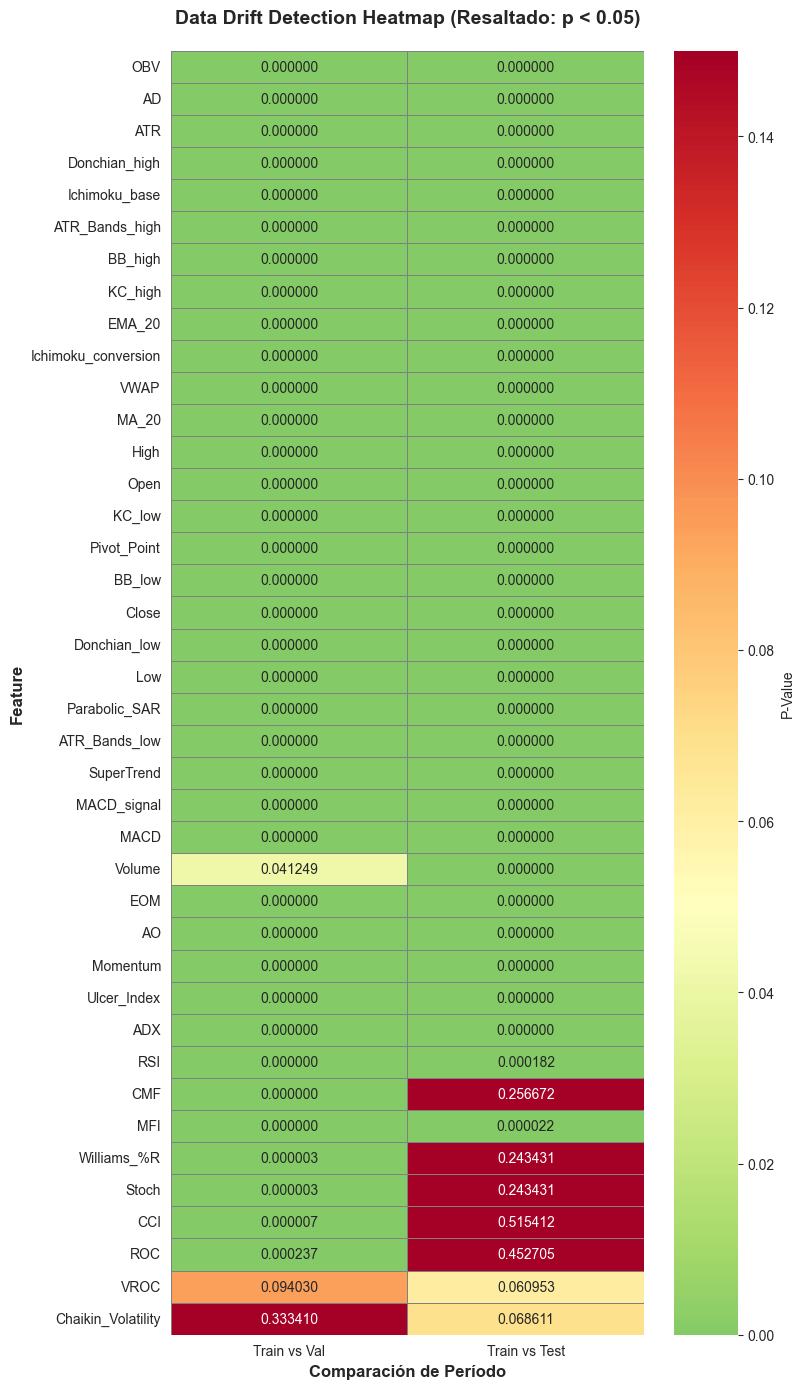


                    🔍 TOP 5 FEATURES CON MAYOR DRIFT 🔍

1. OBV
   Status:          🔴 CRÍTICO
   KS-Statistic:    1.0000
   P-Value:         0.000000
   📝 Interpretación:
      [Magnitud EXTREMA] Cambio en patrones de volumen. Puede indicar cambio en liquidez o interés en el activo.

2. AD
   Status:          🔴 CRÍTICO
   KS-Statistic:    0.9969
   P-Value:         0.000000
   📝 Interpretación:
      [Magnitud EXTREMA] Cambio en patrones de volumen. Puede indicar cambio en liquidez o interés en el activo.

3. ATR
   Status:          🔴 CRÍTICO
   KS-Statistic:    0.9710
   P-Value:         0.000000
   📝 Interpretación:
      [Magnitud EXTREMA] Cambio en volatilidad. Posible transición entre régimen de baja/alta volatilidad.

4. Donchian_high
   Status:          🔴 CRÍTICO
   KS-Statistic:    0.9416
   P-Value:         0.000000
   📝 Interpretación:
      [Magnitud EXTREMA] Cambio en volatilidad. Posible transición entre régimen de baja/alta volatilidad.

5. Ichimoku_base
   Status:       

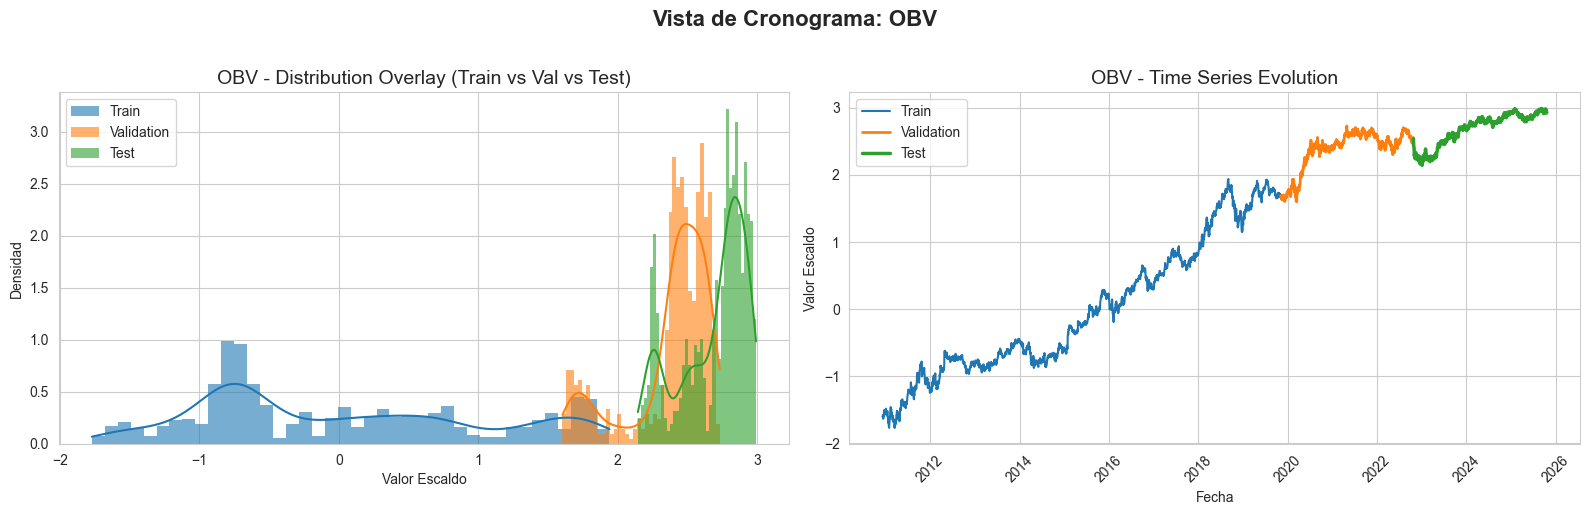


-> Mostrando Timeline para: AD


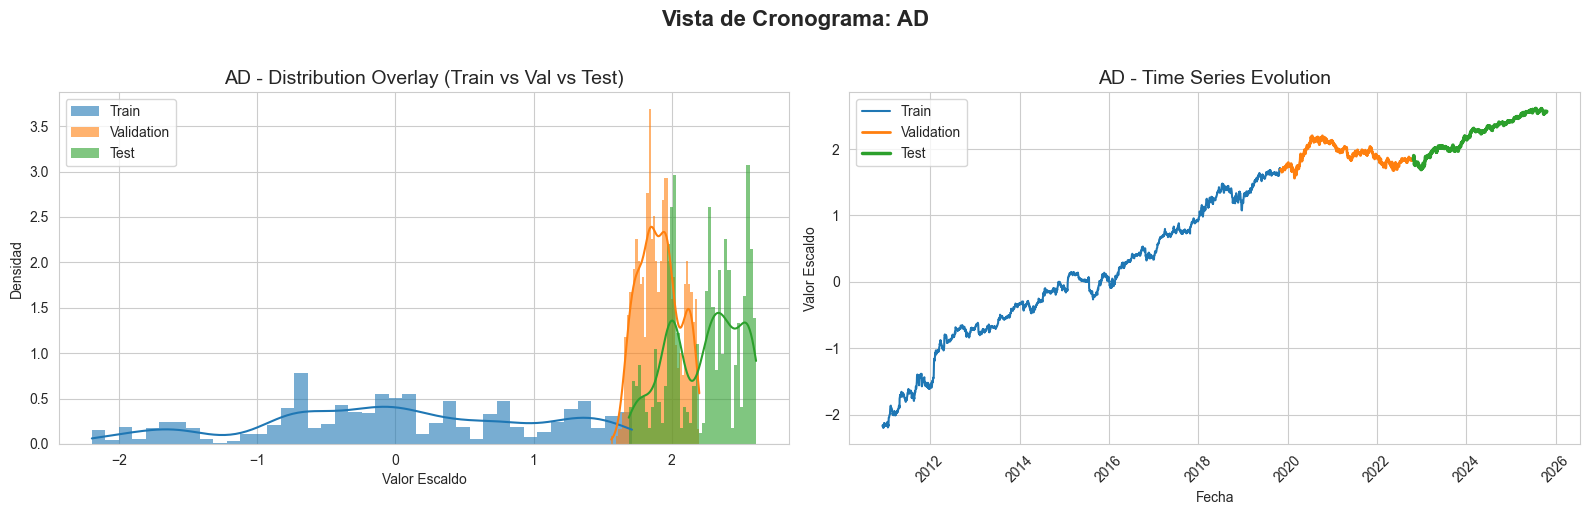


-> Mostrando Timeline para: ATR


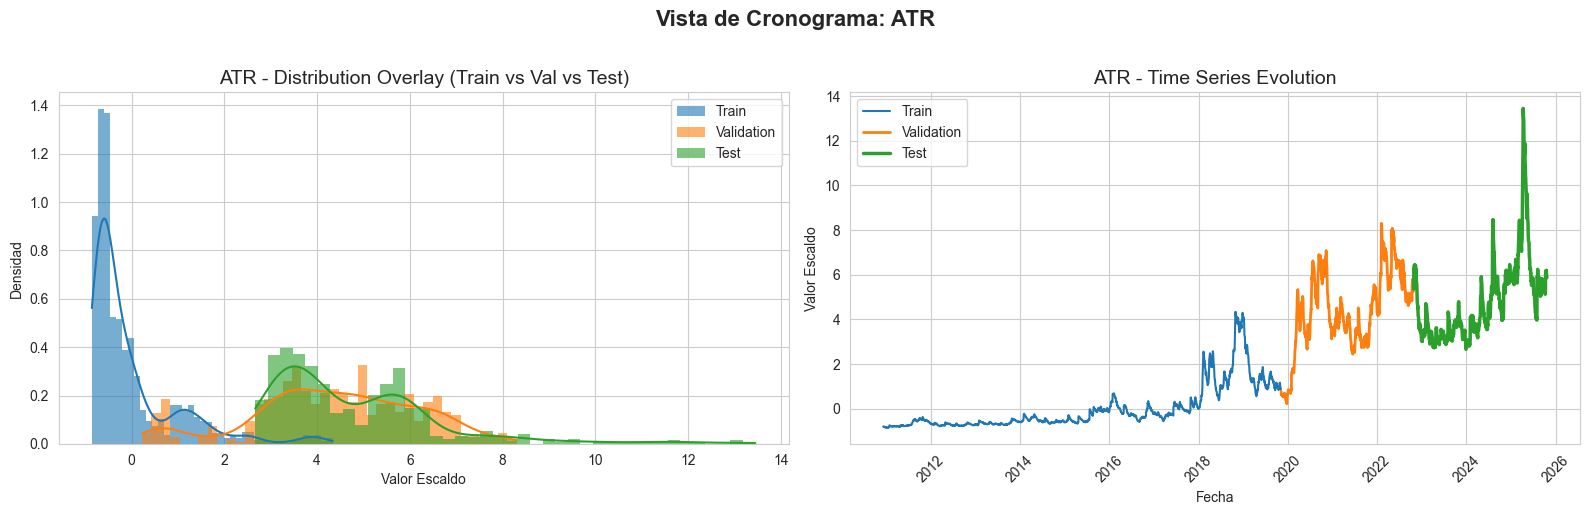


-> Mostrando Timeline para: Donchian_high


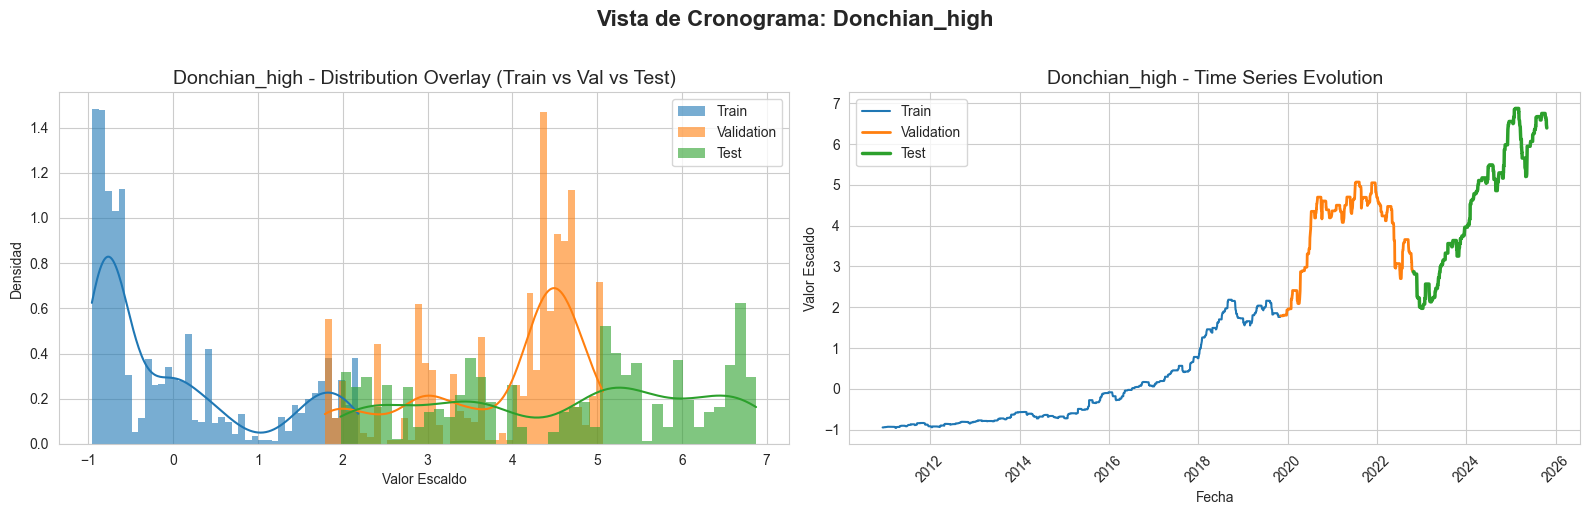


-> Mostrando Timeline para: Ichimoku_base


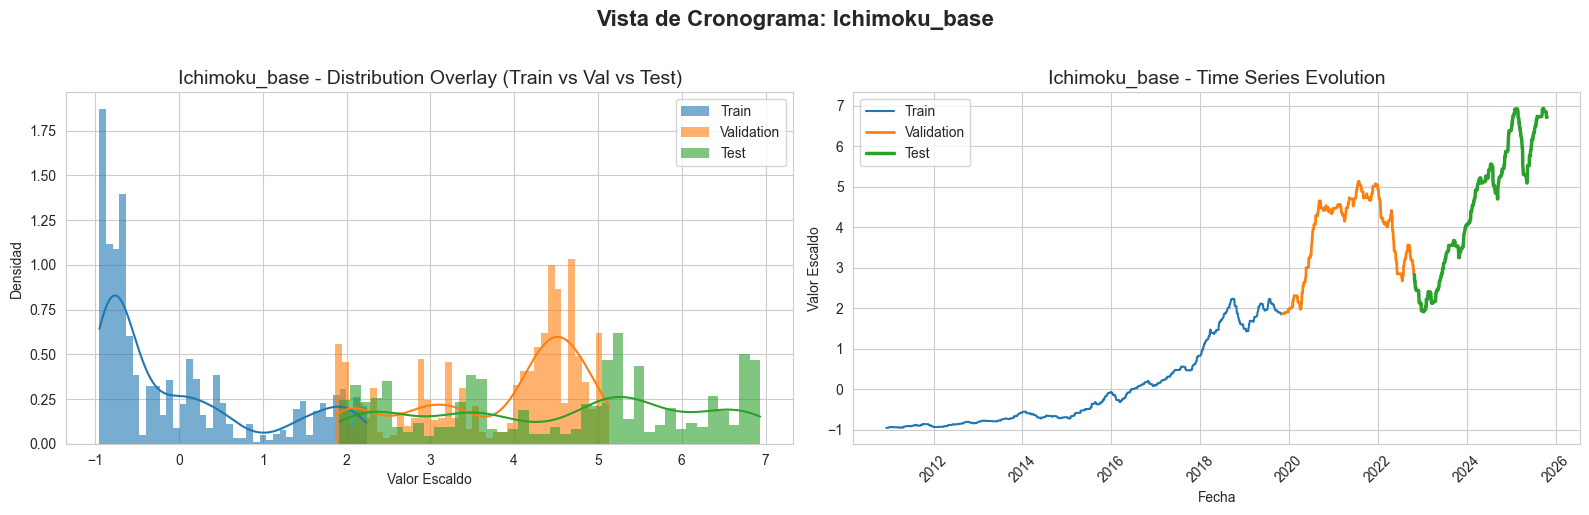


🔍 5. ANÁLISIS DE IMPACTO DEL DRIFT 🔍
📂 Cargando modelos...
✅ Modelos cargados correctamente

--- Performance de Estrategia en Split de Test (Sujeto a Drift) ---
| Métrica      | MLP (Test)   | CNN (Test)   |   Referencia Drift (Max KS-Stat) |
|:-------------|:-------------|:-------------|---------------------------------:|
| Sharpe       | -0.1720      | nan          |                                1 |
| CAGR         | -16.19%      | 0.00%        |                                1 |
| Max_Drawdown | -60.27%      | 0.00%        |                                1 |
| Win_Rate     | 0.4545       | nan          |                                1 |
| Final_Equity | $5,925       | $10,000      |                                1 |

📝 Interpretación del Impacto:
El análisis de drift reveló que 38 de 40 (95%) características presentan desviación significativa (p < 0.05) entre el período de entrenamiento y el de test.
La magnitud del drift (Max KS-Stat = 1.0000) es Extrema en las top 5 feature

In [18]:
# ===================================================================
# 3. Ejecución del Análisis y Presentación de Resultados
# ===================================================================

print("Calculando estadísticas de data drift...")
df_drift = compute_drift_statistics()
df_top5 = generate_top5_summary(df_drift)

# Resumen de detección
total_features = len(df_drift)
features_with_drift = df_drift['Drift_Detected'].sum()
print(f"\nResultados: {total_features} features analizadas. Drift significativo detectado en {features_with_drift} features (p < 0.05).")

# 1. Tabla de Estadísticas (Requisito 2)
display_drift_table_highlighted(df_drift, top_n=10)

# 2. Heatmap de Resaltado (Requisito 3)
print("\n--- 2. Heatmap de Desviación (Resaltado: p < 0.05) ---")
plot_drift_heatmap_mpl(df_drift)

# 3. Resumen Top 5 (Requisito 4)
print_top5_summary(df_top5)

# 4. Vistas de Cronograma (Requisito 1)
print("\n--- 4. Vistas de Cronograma (Timeline View) para Top 5 Features ---")
for _, row in df_top5.iterrows():
    feature = row['Feature']
    print(f"\n-> Mostrando Timeline para: {feature}")
    plot_feature_timeline_mpl(feature)

analyze_drift_impact(df_drift, df_top5)

print("\n" + "="*80)
print("✨ DATA DRIFT ANALYSIS COMPLETE ✨")
print("="*80)